In [2]:
import pandas as pd
import numpy as np
from random import seed
from random import sample

seed(42)
np.random.seed(42)

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import gensim.downloader as api
from gensim.models.keyedvectors import Word2VecKeyedVectors

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy import spatial

from nltk.corpus import stopwords

In [3]:
model = api.load('word2vec-google-news-300')

[=================================================-] 99.0% 1646.2/1662.8MB downloaded

In [5]:
from google.colab import files
uploaded = files.upload()

Saving emaildataset.csv to emaildataset.csv


In [6]:
df = pd.read_csv("./emaildataset.csv", usecols = ['Subject','Body', 'Class'])
df.head()

,Subject,Body,Class
0,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,Pending
1,Order for new Cheque book,"Good morning, I want to place an order for an ...",General
2,Required money acquired. Transaction 847047 is...,Hello! This is to inform you that I have recei...,Processing
3,Asking for the details for transaction 746078,I request you to kindly send the status of my ...,Request
4,Partial payment for transaction 535918,Hello!! Greetings for the day. Status of trans...,Pending


In [7]:
def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

In [8]:
# subj, body to text

for i in range(df.shape[0]):
    # merge subject and body strings
    df['Text'] = (df['Subject'] + " " + df['Body'])

In [9]:
df['Text'] = df['Text'].apply(lambda x: get_only_chars(x))

In [10]:
df = df.drop_duplicates('Text')

In [12]:
# set the by default to :

num_classes = 2 # the number of classes we consider (since the dataset has many classes)
sample_size = 3 # the number of labeled sampled we’ll require from the user

In [13]:
from sklearn.preprocessing import LabelEncoder 

le = LabelEncoder()
# classes = df['Class'].values

# classes = classes.reshape(-1, 1)
# Y = le.fit_transform(classes)
df['Class'] = le.fit_transform(df['Class'])

In [16]:
df.head()
# df.shape

,Subject,Body,Class,Text
0,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,4,transaction no is unresolved sorry to inform t...
1,Order for new Cheque book,"Good morning, I want to place an order for an ...",3,order for new cheque book good morning i want ...
2,Required money acquired. Transaction 847047 is...,Hello! This is to inform you that I have recei...,5,required money acquired transaction is in proc...
3,Asking for the details for transaction 746078,I request you to kindly send the status of my ...,6,asking for the details for transaction i reque...
4,Partial payment for transaction 535918,Hello!! Greetings for the day. Status of trans...,4,partial payment for transaction hello greeting...


In [15]:
df['Class'] = df['Class'].apply(lambda x : x + 1)

In [18]:
# Generate samples that contains K samples of each class

def gen_sample(sample_size, num_classes):

    df_1 = df[(df["Class"] < num_classes+1)].reset_index().drop(["index"], axis=1).reset_index().drop(["index"], axis=1)
    train = df_1[df_1["Class"] == np.unique(df_1['Class'])[0]].sample(sample_size)

    train_index = train.index.tolist()

    for i in range(1,num_classes):
        train_2 = df_1[df_1["Class"] == np.unique(df_1['Class'])[i]].sample(sample_size)
        train = pd.concat([train, train_2], axis=0)
        train_index.extend(train_2.index.tolist())

    test = df_1[~df_1.index.isin(train_index)]
    # return test
    return train, test

In [ ]:
# test = gen_sample(sample_size, num_classes)
# test.head(30)

In [19]:
# Apply that to the dataframe :

train, test = gen_sample(sample_size, num_classes)

X_train = train['Text']
y_train = train['Class'].values
X_test = test['Text']
y_test = test['Class'].values

In [20]:
# train.head(20)
print(train.values[2])

['Received full payment for transaction no. 556678'
 'To whom it may concern, I have successfully received payment for the transaction 556678 . I am grateful for your cooperation. Thank you so much and regards.'
 1
 'received full payment for transaction no to whom it may concern i have successfully received payment for the transaction i am grateful for your cooperation thank you so much and regards ']


In [21]:
# test.head(20)

In [22]:
# print(X_train)

In [23]:
print(X_train.shape)

(6,)


In [24]:
# Text processing (split, find token id, get embedidng)
def transform_sentence(text, model):

    """
    Mean embedding vector
    """

    def preprocess_text(raw_text, model=model):

        """ 
        Excluding unknown words and get corresponding token
        """

        raw_text = raw_text.split()

        return list(filter(lambda x: x in model.vocab, raw_text))

    tokens = preprocess_text(text)

    if not tokens:
        return np.zeros(model.vector_size)

    text_vector = np.mean(model[tokens], axis=0)

    return np.array(text_vector)

In [25]:
# Apply this to both the train and the test :

X_train_mean = X_train.apply(lambda x : transform_sentence(x, model))
X_test_mean = X_test.apply(lambda x : transform_sentence(x, model))

X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

In [27]:
# Use cosine similarity to find closest class

def classify_txt(txt, mean_embedding):

    best_dist = 1
    best_label = -1

    for cl in range(num_classes):

        dist = spatial.distance.cosine(transform_sentence(txt, model), mean_embedding[cl])

        if dist < best_dist :
            best_dist = dist
            best_label = cl + 1 # not cl?

    return best_label

In [28]:
# Process text and predict on the test set

def return_score(sample_size, num_classes):

    train, test = gen_sample(sample_size, num_classes)

    X_train = train['Text']
    y_train = train['Class'].values
    X_test = test['Text']
    y_test = test['Class'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

    mean_embedding = {}
    for cl in range(num_classes):
        mean_embedding[cl] = np.mean((X_train_mean[y_train == cl + 1]), axis=0)

    y_pred = [classify_txt(t, mean_embedding) for t in test['Text'].values]

    return accuracy_score(y_pred, y_test)

In [32]:
# Now, we will iterate on the number of classes (between 2 and 7) and the number of samples (between 1 and 30). 
# We will consider that labeling more than 30 training examples per class is too long.

all_accuracy = {2:[],3:[],4:[],5:[],6:[],7:[]}

for num_samples in range(1,30):
    for num_cl in range(2, 7):
        all_accuracy[num_cl].append(return_score(num_samples,num_cl))

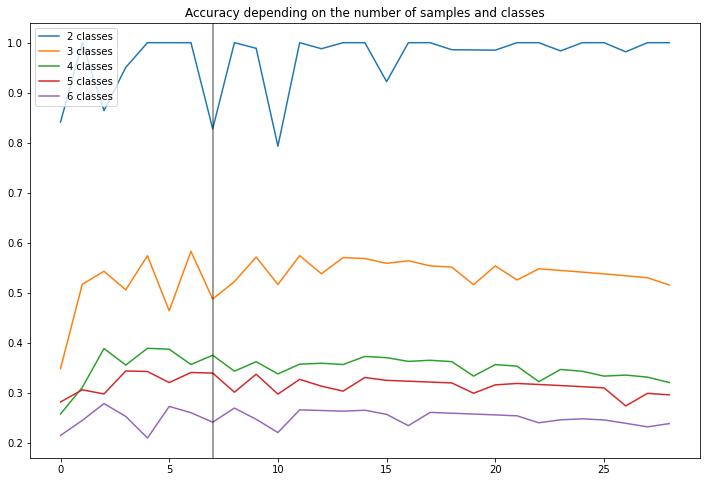

In [33]:
# plotting accuracy for each no. of class, depending on the number of train examples :

plt.figure(figsize=(12,8))
plt.plot(all_accuracy[2], label="2 classes")
plt.plot(all_accuracy[3], label="3 classes")
plt.plot(all_accuracy[4], label="4 classes")
plt.plot(all_accuracy[5], label="5 classes")
plt.plot(all_accuracy[6], label="6 classes")
plt.axvline(7, c='black', alpha=0.5)
plt.title("Accuracy depending on the number of samples and classes")
plt.legend()
plt.show()

## Pre-trained Word2Vec and K-NN

In [40]:
from sklearn.neighbors import KNeighborsClassifier

def return_score(sample_size, num_classes):

    train, test = gen_sample(sample_size, num_classes)

    X_train = train['Text']
    y_train = train['Class'].values
    X_test = test['Text']
    y_test = test['Class'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

    clf = KNeighborsClassifier(n_neighbors=sample_size, p=2)
    clf.fit(X_train_mean, y_train)

    y_pred = clf.predict(X_test_mean)

    return accuracy_score(y_pred, y_test)

In [41]:
all_accuracy_knn = {2:[],3:[],4:[],5:[],6:[],7:[]}

for num_samples in range(1,30):

    for num_cl in range(2, 7):

        all_accuracy_knn[num_cl].append(return_score(num_samples,num_cl))

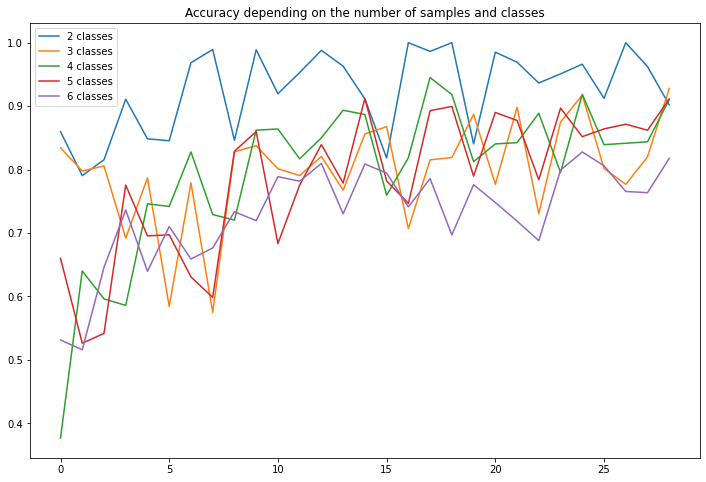

In [42]:
plt.figure(figsize=(12,8))
plt.plot(all_accuracy_knn[2], label="2 classes")
plt.plot(all_accuracy_knn[3], label="3 classes")
plt.plot(all_accuracy_knn[4], label="4 classes")
plt.plot(all_accuracy_knn[5], label="5 classes")
plt.plot(all_accuracy_knn[6], label="6 classes")
plt.title("Accuracy depending on the number of samples and classes")
plt.legend()
plt.show()

## Summary

In [43]:
df_results = pd.DataFrame({
    'Nb Classes':[2,3,4,5], 
    'min K-NN':[min(all_accuracy_knn[2]), 
        min(all_accuracy_knn[3]), 
        min(all_accuracy_knn[4]), 
        min(all_accuracy_knn[5])],
    'min Cosine':[min(all_accuracy[2]), 
        min(all_accuracy[3]), 
        min(all_accuracy[4]), 
        min(all_accuracy[5])],
    'mean K-NN':[np.mean(all_accuracy_knn[2]), 
        np.mean(all_accuracy_knn[3]), 
        np.mean(all_accuracy_knn[4]), 
        np.mean(all_accuracy_knn[5])],
    'mean Cosine':[np.mean(all_accuracy[2]), 
        np.mean(all_accuracy[3]), 
        np.mean(all_accuracy[4]), 
        np.mean(all_accuracy[5])],
    'max K-NN':[max(all_accuracy_knn[2]), 
        max(all_accuracy_knn[3]), 
        max(all_accuracy_knn[4]), 
        max(all_accuracy_knn[5])],
    'max Cosine':[max(all_accuracy[2]), 
        max(all_accuracy[3]), 
        max(all_accuracy[4]), 
        max(all_accuracy[5])]
    })

In [44]:
df_results

,Nb Classes,min K-NN,min Cosine,mean K-NN,mean Cosine,max K-NN,max Cosine
0,2,0.790476,0.793103,0.925077,0.968878,1.000000,1.000000
1,3,0.575000,0.348066,0.799216,0.533000,0.927835,0.582822
2,4,0.376866,0.257463,0.796981,0.349771,0.945000,0.388889
3,5,0.526316,0.273743,0.783580,0.314650,0.912134,0.343537
